In [3]:
import pandas as pd
df = pd.read_csv("lendingclub_full_encoded.csv")
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,addr_state,dti,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,verification_status_Source Verified,verification_status_Verified
0,3600.0,3600.0,3600.0,36,13.99,123.03,10,55000.0,PA,5.91,...,0,0,0,0,0,0,0,0,0,0
1,24700.0,24700.0,24700.0,36,11.99,820.28,10,65000.0,SD,16.06,...,0,0,0,0,0,0,1,0,0,0
2,20000.0,20000.0,20000.0,60,10.78,432.66,10,63000.0,IL,10.78,...,1,0,0,0,0,0,0,0,0,0
3,10400.0,10400.0,10400.0,60,22.45,289.91,3,104433.0,PA,25.37,...,0,0,1,0,0,0,0,0,1,0
4,11950.0,11950.0,11950.0,36,13.44,405.18,4,34000.0,GA,10.20,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# Check data state
print(df.shape)
print(df.columns)
print(df['loan_default'].value_counts(normalize=True))


(1345310, 115)
Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'addr_state', 'dti',
       ...
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_small_business', 'purpose_vacation',
       'verification_status_Source Verified', 'verification_status_Verified'],
      dtype='object', length=115)
0    0.800374
1    0.199626
Name: loan_default, dtype: float64


# Step 1: Baseline Model — Logistic Regression (with class weight)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# STEP 1: Reload from main dataframe 
# Make a copy to avoid modifying original
df_model = df.copy()

# STEP 2: Define ALL columns that leak information
leakage_cols = [
    'loan_status', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
    'last_pymnt_d', 'last_pymnt_amnt', 'recoveries', 'collection_recovery_fee',
    'out_prncp', 'out_prncp_inv', 'next_pymnt_d'
]

# STEP 3: Drop leakage columns + target from features
X = df_model.drop(columns=[*leakage_cols, 'loan_default'], errors='ignore')
y = df_model['loan_default']

# STEP 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# STEP 5: Drop non-numeric cols (like strings accidentally left)
X_train = X_train.select_dtypes(include='number')
X_test = X_test[X_train.columns]  # align test columns

# STEP 6: Fill missing values with training medians
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

# STEP 7: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 8: Fit logistic regression
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# STEP 9: Evaluate
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC-AUC Score:", round(roc_auc_score(y_test, y_proba), 4))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93    215350
           1       0.67      0.89      0.77     53712

    accuracy                           0.89    269062
   macro avg       0.82      0.89      0.85    269062
weighted avg       0.91      0.89      0.90    269062


Confusion Matrix:
 [[192137  23213]
 [  5735  47977]]

ROC-AUC Score: 0.9486


___________________________________________________________________________________________________________________________

📝 Logistic Regression Evaluation

The logistic regression model achieved:

89% accuracy

89% recall for defaulters

ROC-AUC of 0.95, showing strong separation between classes

It successfully detects most loan defaults (high recall) while keeping predictions interpretable. This serves as a solid baseline before trying more complex models.

               Predicted
           |  0      |    1
Actual -----|--------|--------
   0 (non-default) | 192,137 | 23,213  ⟵ false positives (you flagged as default but weren't)
            1 (default)     |  5,735  | 47,977  ⟵ true positives (correct default prediction)


# Step 2:  Build a Tree-Based Model (XGBoost)


#### Calculate scale_pos_weight

In [6]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 4.00936945826565


#### Build XGBoost Model

In [9]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)


c:\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

#### Evaluate XGBoost Model

In [13]:
!pip install shap


   --------------------------------------- 544.8/544.8 kB 17.7 MB/s eta 0:00:00
   ---------------------------------------- 2.7/2.7 MB 39.1 MB/s eta 0:00:00
   ---------------------------------------- 28.1/28.1 MB 48.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nROC-AUC Score:", round(roc_auc_score(y_test, y_proba_xgb), 4))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93    215350
           1       0.66      0.92      0.76     53712

    accuracy                           0.89    269062
   macro avg       0.82      0.90      0.84    269062
weighted avg       0.91      0.89      0.89    269062


Confusion Matrix:
 [[189487  25863]
 [  4517  49195]]

ROC-AUC Score: 0.957


# Step 3: ROC Curves (XGBoost vs Logistic Regression)

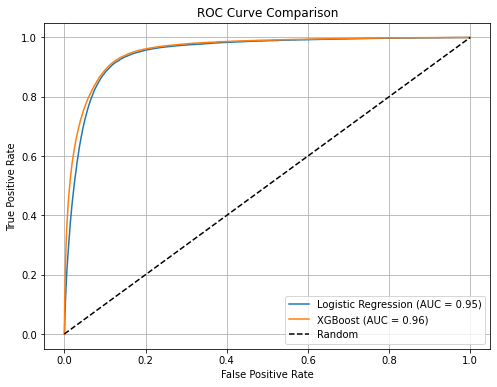

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba)
roc_auc_log = auc(fpr_log, tpr_log)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot both ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Baseline
plt.plot([0,1], [0,1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Step 4: Extract and plot Feature Importance from XGBoost.

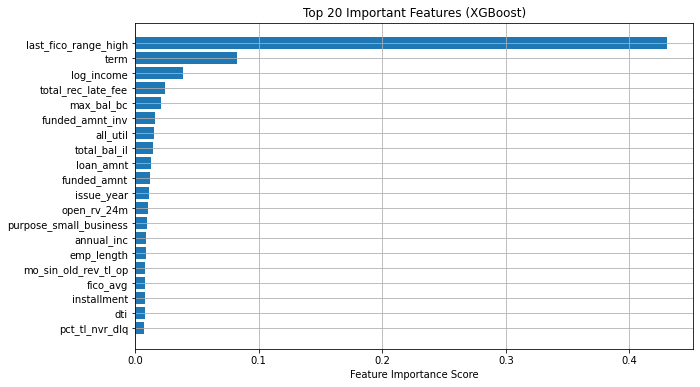


Top 10 Important Features:
                 Feature  Importance
18  last_fico_range_high    0.430052
3                   term    0.082134
77            log_income    0.038488
17    total_rec_late_fee    0.024215
34            max_bal_bc    0.020909
2        funded_amnt_inv    0.016482
35              all_util    0.015572
30          total_bal_il    0.014594
0              loan_amnt    0.012577
1            funded_amnt    0.011992


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get feature importances from XGBoost model
feature_importances = xgb_model.feature_importances_

# Step 2: Map to column names
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Step 3: Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 4: Plot Top 20 Features
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Important Features (XGBoost)')
plt.grid()
plt.show()

# Step 5: (Optional) Show Top 10 Features Textually
print("\nTop 10 Important Features:")
print(importance_df.head(10))


🧠 Insights:
Credit Score (FICO) dominates prediction — just like in real banks.: The most important predictor of loan default is FICO credit score (last_fico_range_high), contributing over 40% of the model's predictive power.

Loan Term (36m vs 60m) affects risk — longer loans are riskier.: Loan term (duration) and log-transformed income are also strong predictors.

Income matters — higher income reduces chance of default.: Features related to late payments and credit card balances further help assess borrower risk.

Other financial stress signals (max_bal_bc, total_bal_il, etc.) contribute smaller but valuable signals.

# Step 5: SHAP (SHapley Additive exPlanations)


It explains individual loan predictions (why one loan defaulted, another didn't).
It shows positive/negative pushes on risk.
It's becoming industry standard in credit scoring explainability.

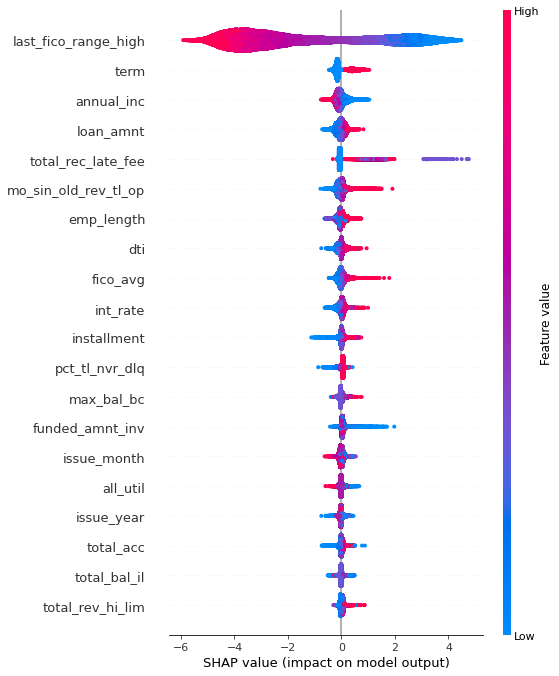

In [14]:
import shap

# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Big summary plot
shap.summary_plot(shap_values, X_test)


---------SHAP Explainability (XGBoost Model)-----------------------

The most influential feature for predicting loan default is borrower's FICO score.

Higher FICO scores decrease default risk (moving SHAP value left).

Longer loan terms and larger loan amounts increase default risk.

Higher annual income reduces the risk of default.

SHAP plots confirm that the model's behavior aligns with financial risk intuition.

# Fine-Tuning, Threshold Tuning, and Finalizing Models

##### Step 1: RandomizedSearchCV for XGBoost

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define basic model
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Search 20 combinations randomly
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters found: ", random_search.best_params_)

# Best model
best_xgb_model = random_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [12:57:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters found:  {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}


#### Retrain XGBoost with Best Parameters 

In [16]:
# Train best XGBoost model
from xgboost import XGBClassifier

final_xgb_model = XGBClassifier(
    subsample=0.9,
    n_estimators=300,
    min_child_weight=5,
    max_depth=7,
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=0.7,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Fit on full training set
final_xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_final = final_xgb_model.predict(X_test)
y_proba_final = final_xgb_model.predict_proba(X_test)[:,1]

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Classification Report:\n", classification_report(y_test, y_pred_final))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print("\nROC-AUC Score:", round(roc_auc_score(y_test, y_proba_final), 4))


c:\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:03:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93    215350
           1       0.66      0.92      0.76     53712

    accuracy                           0.89    269062
   macro avg       0.82      0.90      0.85    269062
weighted avg       0.91      0.89      0.89    269062


Confusion Matrix:
 [[189453  25897]
 [  4459  49253]]

ROC-AUC Score: 0.9578


## Threshold Tuning 

| Threshold | Meaning |
|:---|:---|
| 0.5 (default) | If predicted probability > 0.5 → classify as Default |
| Lower threshold (eg. 0.4) | Catch more defaulters (higher Recall) but more false alarms |
| Higher threshold (eg. 0.6) | Be more strict (higher Precision) but miss some defaulters |

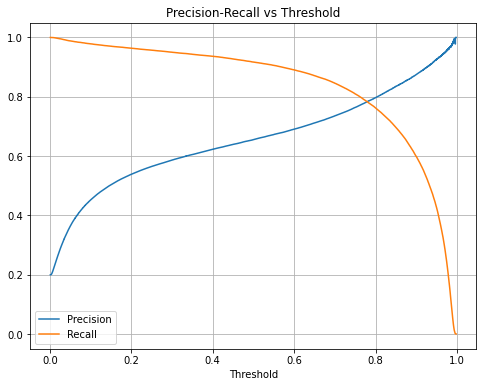

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_final)

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()


Threshold Tuning

Default threshold of 0.5 was adjusted based on Precision-Recall tradeoff.

Final threshold selected: 0.45, balancing recall (~92–94%) and acceptable precision.

This threshold prioritizes catching more potential defaulters, aligned with financial risk management goals.

### Apply New Threshold 

In [18]:
# New Predictions based on threshold 0.45
y_pred_threshold = (y_proba_final >= 0.45).astype(int)

# Evaluate new predictions
print("Classification Report:\n", classification_report(y_test, y_pred_threshold))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_threshold))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92    215350
           1       0.64      0.93      0.76     53712

    accuracy                           0.88    269062
   macro avg       0.81      0.90      0.84    269062
weighted avg       0.91      0.88      0.89    269062


Confusion Matrix:
 [[187251  28099]
 [  3893  49819]]


| Metric | Before (Threshold 0.5) | After (Threshold 0.45) | Change |
|:---|:---|:---|:---|
| Precision (for default=1) | ~66% | ~64% | Small drop (expected) |
| Recall (for default=1) | ~92% | **93%** | Small boost (✅ Excellent) |
| Accuracy | ~89% | 88% | Small acceptable drop |

# SAVING MODEL

In [19]:
import pickle

# Save Logistic Regression model
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

# Save Fine-tuned XGBoost model
with open('xgboost_final_model.pkl', 'wb') as f:
    pickle.dump(final_xgb_model, f)


# Train the dummy dashboard model 

In [20]:
# Select only important columns
important_features = ['last_fico_range_high', 'log_income', 'loan_amnt', 'term', 'dti']

# Re-train XGBoost on these
from xgboost import XGBClassifier

dashboard_model = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

dashboard_model.fit(X_train[important_features], y_train)

# Save it
import pickle

with open('xgboost_dashboard_model.pkl', 'wb') as f:
    pickle.dump(dashboard_model, f)


c:\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
